In [304]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# get different stemmers
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer 
  

import string
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score
from scikitplot.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [305]:
def read_merge_data():
    data = pd.read_csv("labeled_data.csv")
    train = pd.read_csv("train_kaggle.csv")
    test = pd.read_csv("test.csv")
    test_labels = pd.read_csv("test_labels.csv")
    train_big = pd.read_csv("train.csv")
    del data["Unnamed: 0"]
    train_big["label"] = np.where((train_big["identity_hate"] + train_big["severe_toxic"] + train_big["toxic"] + train_big["obscene"] + train_big["insult"] + train_big["threat"]) == 0, 0, 1)
    for col in ['toxic', 'severe_toxic', 'obscene', 'threat',
           'insult', 'identity_hate']:
        test_labels = test_labels[test_labels[col] != -1]
    test_labels["label"] = np.where((test_labels["identity_hate"] + test_labels["severe_toxic"] + test_labels["toxic"] + test_labels["obscene"] + test_labels["insult"] + test_labels["threat"]) == 0, 0, 1)
    test = pd.merge(test, test_labels[["id", "label"]], how="inner")
    data["label"] = np.where(data["class"]==2, 0, 1)
    return data, train, train_big

def prep_data(data, train, train_big):
    data = data[["tweet", "label"]]
    train = train[["tweet", "label"]]
    train_big.columns = train_big.columns.str.replace('comment_text', 'tweet')
    train_big = train_big[["tweet", "label"]]
    df = data.append(train).append(train_big).reset_index()
    del df["index"]
    df['tweet_length'] = df['tweet'].apply(len)
    return df

In [306]:
data, train, train_big = read_merge_data()
df = prep_data(data, train, train_big)

In [307]:
df.label.value_counts()

0    177229
1     39087
Name: label, dtype: int64

# Plot tweet length ditribtuion

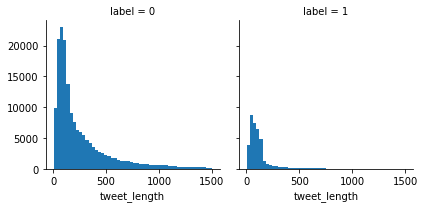

In [313]:
graph = sns.FacetGrid(data=df, col='label')
graph.map(plt.hist, 'tweet_length', bins=50)

In [314]:
def filter_tweet_length(df, tweet_size=1500):
    df = df[df["tweet_length"]<tweet_size].reset_index()
    del df["index"]
    return df

In [315]:
df = filter_tweet_length(df, tweet_size = 1500)

# Plot tweet legnth distribtuion after filtering

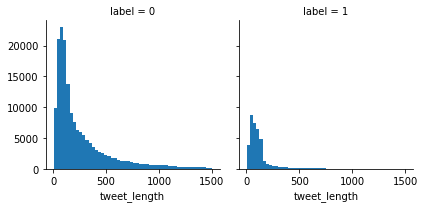

In [316]:
graph = sns.FacetGrid(data=df, col='label')
graph.map(plt.hist, 'tweet_length', bins=50)

In [317]:
tweets = df.tweet
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
porter = PorterStemmer()
snowball = SnowballStemmer(language='english')
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [318]:
def preprocess(tweet, porter, snowball, lancaster, lemmatizer):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    
    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')
        
    print("removing the URL")
    url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(url_regex, '')
    
    
    print("removing numbers and punctuation")
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    
    print("Trimming whitespace to a single whitespace between words")
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    
    print("Trimming trailing whitespace")
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    
    print("Converting to lower")
    tweet_lower = newtweet.str.lower()
    
    print("Tokenizing!")
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    print("Removing stopwords!")
    tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    print("Stemming Porter!")
    processed_porter_tweets = tokenized_tweet.apply(lambda x: [porter.stem(i) for i in x])
    
    print("Stemming Snowball!")
    processed_snowball_tweets = tokenized_tweet.apply(lambda x: [snowball.stem(i) for i in x])
    
    print("Stemming Lancaster!")
    processed_lancaster_tweets = tokenized_tweet.apply(lambda x: [lancaster.stem(i) for i in x])
    
    print("Lemmatizing with WordNet!")
    processed_lemmatized_tweets = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    
    return processed_porter_tweets, processed_snowball_tweets, processed_lancaster_tweets, processed_lemmatized_tweets


processed_porter_tweets, processed_snowball_tweets, processed_lancaster_tweets, processed_lemmatized_tweets = preprocess(tweets, porter, snowball, lancaster, lemmatizer)   



removing the URL
removing numbers and punctuation
Trimming whitespace to a single whitespace between words
Trimming trailing whitespace
Converting to lower
Tokenizing!
Removing stopwords!
Stemming Porter!
Stemming Snowball!
Stemming Lancaster!
Lemmatizing with WordNet!


In [319]:
def prep_tweet(tokenized_tweet):
    for i in tqdm(range(len(tokenized_tweet))):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p = tokenized_tweet
    return tweets_p

prep_porter_tweets = prep_tweet(processed_porter_tweets)
prep_snowball_tweets = prep_tweet(processed_snowball_tweets)
prep_lancaster_tweets = prep_tweet(processed_lancaster_tweets)
prep_lemmatizer_tweets = prep_tweet(processed_lemmatized_tweets)

df['processed_porter_tweets'] = prep_porter_tweets
df['processed_snowball_tweets'] = prep_snowball_tweets
df['processed_lancaster_tweets'] = prep_lancaster_tweets
df['processed_lemmatized_tweets'] = prep_lemmatizer_tweets


100%|██████████| 209637/209637 [00:05<00:00, 35170.79it/s]


In [320]:
df[["processed_porter_tweets", "processed_snowball_tweets", "processed_lancaster_tweets", "processed_lemmatized_tweets"]].head(5)

,processed_porter_tweets,processed_snowball_tweets,processed_lancaster_tweets,processed_lemmatized_tweets
0,woman complain clean hous amp man alway take t...,woman complain clean hous amp man alway take t...,wom complain cle hous amp man alway tak trash,woman complain cleaning house amp man always t...
1,boy dat cold tyga dwn bad cuffin dat hoe st place,boy dat cold tyga dwn bad cuffin dat hoe st place,boy dat cold tyg dwn bad cuffin dat hoe st plac,boy dat cold tyga dwn bad cuffin dat hoe st place
2,dawg ever fuck bitch start cri confus shit,dawg ever fuck bitch start cri confus shit,dawg ev fuck bitch start cry confus shit,dawg ever fuck bitch start cry confused shit
3,look like tranni,look like tranni,look lik tranny,look like tranny
4,shit hear might true might faker bitch told ya,shit hear might true might faker bitch told ya,shit hear might tru might fak bitch told ya,shit hear might true might faker bitch told ya


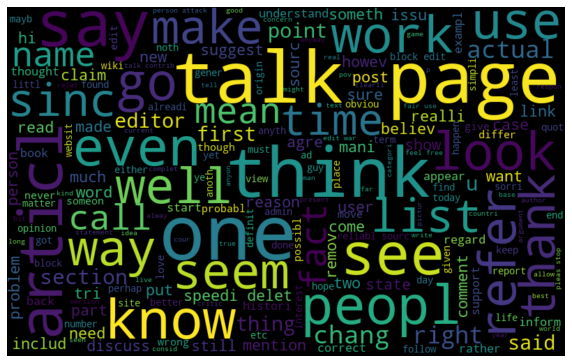

In [134]:
# visualizing which of the word is most commonly used in the twitter dataset
from wordcloud import WordCloud
nice_words = ' '.join([text for text in df['processed_porter_tweets'][df['label'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(nice_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

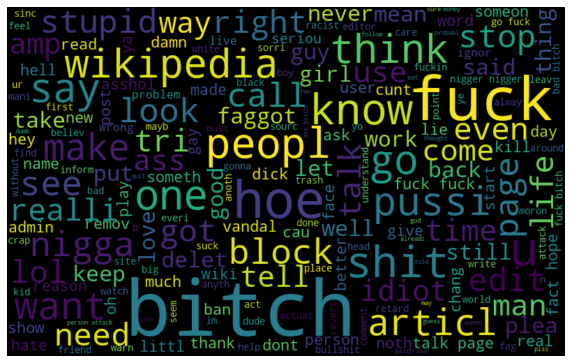

In [135]:
# visualizing which of the word is most commonly used for hatred speech
hatred_words = ' '.join([text for text in df['processed_porter_tweets'][df['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:

#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=2, max_features=10000)

# TF-IDF feature matrix
tfidf_porter = tfidf_vectorizer.fit_transform(df['processed_porter_tweets'] )
print(tfidf_porter.shape)

tfidf_snowball = tfidf_vectorizer.fit_transform(df['processed_snowball_tweets'] )
print(tfidf_snowball.shape)

tfidf_lancaster = tfidf_vectorizer.fit_transform(df['processed_lancaster_tweets'] )
print(tfidf_lancaster.shape)

tfidf_lemmatizer = tfidf_vectorizer.fit_transform(df['processed_lemmatized_tweets'] )
print(tfidf_lancaster.shape)

(209637, 10000)


In [ ]:
print("Running classification algorithms with the Porter stemmer")
X = tfidf_porter
y = df['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
acc_lr_porter=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc_lr_porter)
roc_auc_lr_porter = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_lr_porter)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc_rf_porter =accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Random Forest, Accuracy Score:",acc_rf_porter)
roc_auc_rf_porter = roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_rf_porter)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc_nb_porter=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Naive Bayes, Accuracy Score:",acc_nb_porter)
roc_auc_nb_porter = roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_nb_porter)

In [ ]:
print("Running classification algorithms with the Porter2 stemmer")
X = tfidf_snowball
y = df['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
acc_lr_porter=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc_lr_porter)
roc_auc_lr_porter = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_lr_porter)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc_rf_porter =accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Random Forest, Accuracy Score:",acc_rf_porter)
roc_auc_rf_porter = roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_rf_porter)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc_nb_porter=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Naive Bayes, Accuracy Score:",acc_nb_porter)
roc_auc_nb_porter = roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_nb_porter)

In [ ]:
print("Running classification algorithms with the Lemmatizer")
X = tfidf_lemmatizer
y = df['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
acc_lr_snowball=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc_lr_snowball)
roc_auc_lr_snowball = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_lr_snowball)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc_rf_snowball=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Random Forest, Accuracy Score:",acc_rf_snowball)


roc_auc_rf_snowball = roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_rf_snowball)

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc_nb_snowball=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Naive Bayes, Accuracy Score:",acc_nb_snowball)

roc_auc_nb_snowball = roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_nb_snowball)

In [ ]:
print("Running classification algorithms with the Lancaster stemmer")
X = tfidf_lancaster
y = df['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
acc_lr_lancaster=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc_lr_lancaster)
roc_auc_lr_lancaster = roc_auc_score(y_test, model.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_lr_lancaster)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc_rf_lancaster=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Random Forest, Accuracy Score:",acc_rf_lancaster)
roc_auc_rf_lancaster = roc_auc_score(y_test, rf.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_rf_lancaster)

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc_nb_lancaster = accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print(confusion_matrix(y_test,y_preds))
print("Naive Bayes, Accuracy Score:",acc_nb_lancaster)
roc_auc_nb_lancaster = roc_auc_score(y_test, nb.predict_proba(X_test_tfidf)[:,1])
print("ROC AUC score: ", roc_auc_nb_lancaster)

In [ ]:
objects = ("Porter", "Porter2", "Lancaster")
y_pos = np.arange(len(objects))
performance = [acc_lr_porter, acc_lr_snowball, acc_lr_lancaster]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Logsitci Regression Comparision for different stemmers')
plt.show()

In [ ]:

objects = ("Porter", "Lemmatizer", "Lancaster")
y_pos = np.arange(len(objects))
performance = [acc_rf_porter, acc_rf_snowball, acc_rf_lancaster]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Random Forest Comparision for different stemmers - accuracy')
plt.show()

In [ ]:

objects = ("Porter Logistic Regression", "Snowball Logistic Regression", "Lancaster Logistic Regression", "Porter Random Forest", "Snowball Random Forest", "Lancaster Random Forest", "Porter Naive Bayes", "Snowball Naive Bayes", "Lancaster Naive Bayes")
y_pos = np.arange(len(objects))
performance = [acc_lr_porter, acc_lr_snowball, acc_lr_lancaster, acc_rf_porter, acc_rf_snowball, acc_rf_lancaster, acc_nb_porter, acc_nb_snowball, acc_nb_lancaster]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Accuracy')
plt.title('Logsitci Regression Comparision for different stemmers')
plt.show()

In [ ]:

objects = ('Logistic', 'RandomForest', 'Naive_bayes')
y_pos = np.arange(len(objects))
performance = [roc_auc_1,roc_auc_2,roc_auc_3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('ROC AUC Score')
plt.title('Algorithm Comparision for ROC AUC')
plt.show()